**Background and Context:**

Twitter posses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other side, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/services on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand, and their competitors, and discover new trends in the industry.

**Data Description:**

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

**Objective:**

To implement the techniques learned as a part of the course.

* Basic understanding of text pre-processing.
* What to do after text pre-processing
* Bag of words
* Tf-idf
* Build the classification model.
* Evaluate the Model

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import re
import string
import os
!pip install emoji
import emoji
from pprint import pprint
from time import time
import collections
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import gensim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


     |████████████████████████████████| 133kB 7.3MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from google.colab import files
upload = files.upload()

Saving Tweets.csv to Tweets.csv


In [3]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index)) 
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)
df = df[['text', 'airline_sentiment']]
df.head(10)

,text,airline_sentiment
0,@SouthwestAir can you make a premium wifi that I can pay $30 for that is decent? #slow-fi,negative
1,@USAirways thanks! Made it safely! http://t.co/KCqeBEej7S,positive
2,@AmericanAir now down to only one agent helping a stagnant line of almost 100 customers. Super.,negative
3,@SouthwestAir Just sent DM with confirmation number and passenger name on SWA 3104 MCO-&gt;CMH,neutral
4,"@AmericanAir that's unacceptable. They should allow me to wait on hold, or take my number and call me themselves.",negative
5,"@united v upset with your disability ""services"". When I told one of your employees I was carrying medical equipment she was very rude.",negative
6,@USAirways on the phone over an hour waiting for customer service got wrong fight information cost us 6 hours from trip. Frustrating!!!,negative
7,@AmericanAir any ways to get through the 50 minute wait to book a flight?,negative
8,@united holy high speed internet batman! Speeds at United Club at IAD are insanely fast! Thanks,positive
9,@united lots of reports of system failures delaying flights over the last week. Currently sitting on the tarmac at OGG for over an hour.,negative


**Exploratory Analysis and Preprocessing** 

In [4]:

class TextCounts(BaseEstimator, TransformerMixin):

  #Identifying the substring patterns in the tweet  
  
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))

  #Fit method on the train data 
  
    def fit(self, X, y=None, **fit_params):
        return self

  #Pre-processing all the alphanumeric character 

    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?+', x))
        count_urls = X.apply(lambda x: self.count_regex(r'https?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))

        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

**Exploratory Analysis**

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

tc = TextCounts()

df_djb = tc.fit_transform(df.text)
df_djb['airline_sentiment'] = df.airline_sentiment
df_djb.head(10)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment
0,18,1,1,0,1,0,0,negative
1,9,1,0,0,2,1,0,positive
2,16,1,0,0,0,0,0,negative
3,16,1,0,4,0,0,0,neutral
4,20,1,0,0,0,0,0,negative
5,23,1,0,0,0,0,0,negative
6,22,1,0,0,3,0,0,negative
7,14,1,0,0,1,0,0,negative
8,16,1,0,1,2,0,0,positive
9,24,1,0,1,0,0,0,negative


In [6]:
df_djb['airline_sentiment'] = df.airline_sentiment
df_djb.head(10)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment
0,18,1,1,0,1,0,0,negative
1,9,1,0,0,2,1,0,positive
2,16,1,0,0,0,0,0,negative
3,16,1,0,4,0,0,0,neutral
4,20,1,0,0,0,0,0,negative
5,23,1,0,0,0,0,0,negative
6,22,1,0,0,3,0,0,negative
7,14,1,0,0,1,0,0,negative
8,16,1,0,1,2,0,0,positive
9,24,1,0,1,0,0,0,negative


In [7]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="brg")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  20.387557  6.100020  2.0  17.0  22.0  25.0  35.0
neutral            3099.0  15.290094  7.150738  2.0  10.0  15.0  21.0  34.0
positive           2363.0  14.478206  7.266129  2.0  8.0   14.0  21.0  33.0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


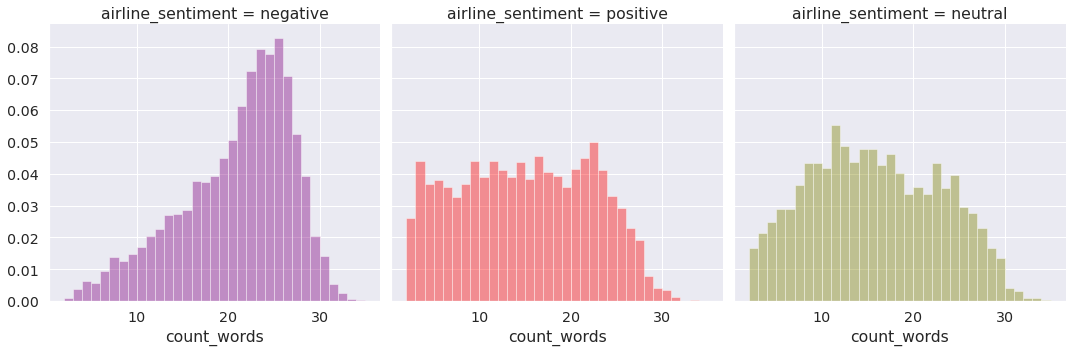

In [8]:
show_dist(df_djb, 'count_words')

Insights

The largest number of words is 30(+) and negative tweets contain more words than both neutral or positive tweets.

Descriptive stats for count_mentions
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  1.111244  0.365420  1.0  1.0  1.0  1.0  6.0
neutral            3099.0  1.167473  0.480102  1.0  1.0  1.0  1.0  5.0
positive           2363.0  1.138383  0.432462  1.0  1.0  1.0  1.0  6.0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


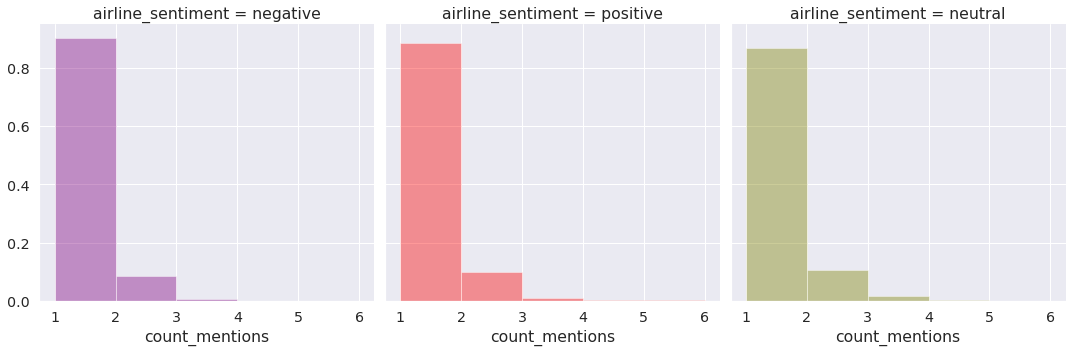

In [9]:
show_dist(df_djb, 'count_mentions')

Insights

All tweets have at least one mention based on the result of extracting the tweets based on mentions in the Twitter data. However, there is no difference in the number of mentions with respect to the sentiment.


Descriptive stats for count_hashtags
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.233384  0.615099  0.0  0.0  0.0  0.0  6.0
neutral            3099.0  0.212004  0.666382  0.0  0.0  0.0  0.0  6.0
positive           2363.0  0.297503  0.774776  0.0  0.0  0.0  0.0  8.0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


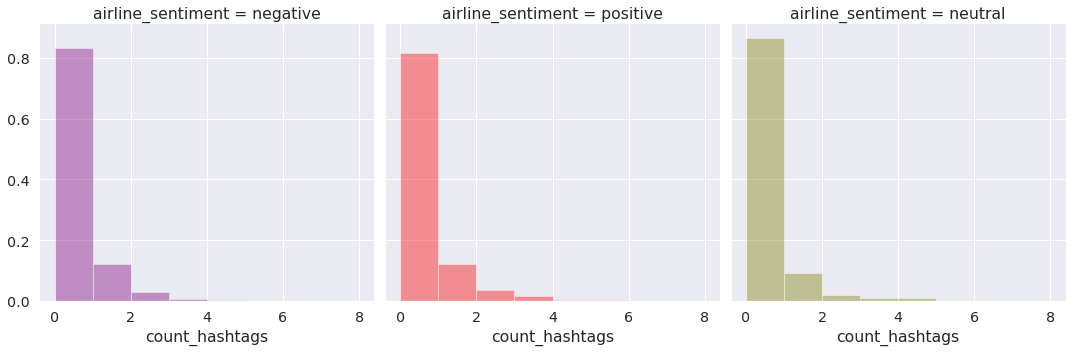

In [10]:
show_dist(df_djb, 'count_hashtags')

Insights:

According to the data most of the tweets doesnt contain hash tags an there is no difference in the number of hash tags with respect to the sentiment.

Descriptive stats for count_capital_words
-----------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.429070  1.019710  0.0  0.0  0.0  1.0  22.0
neutral            3099.0  0.462085  0.939468  0.0  0.0  0.0  1.0  11.0
positive           2363.0  0.461278  1.234078  0.0  0.0  0.0  1.0  20.0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


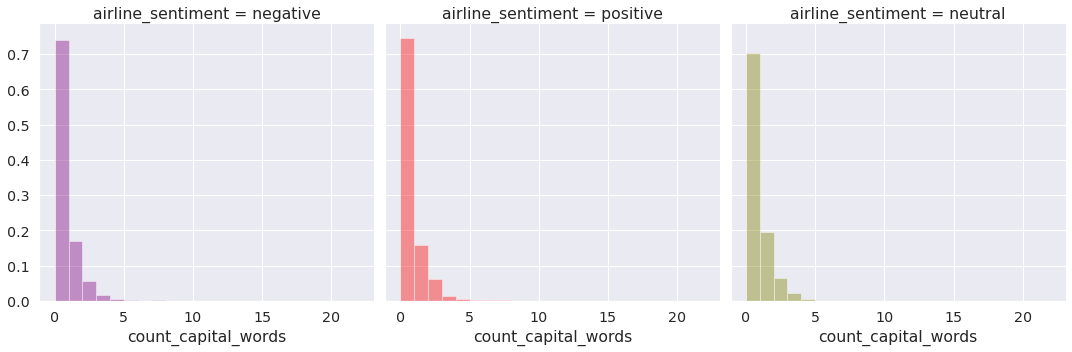

In [11]:
show_dist(df_djb, 'count_capital_words')

Insights:

According to the data most of the tweets do not contain capitailzed words and there is no difference in sentiment

Descriptive stats for count_excl_quest_marks
--------------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.589235  1.041339  0.0  0.0  0.0  1.0  27.0
neutral            3099.0  0.639238  0.868104  0.0  0.0  0.0  1.0  12.0
positive           2363.0  0.890394  1.198117  0.0  0.0  1.0  1.0  13.0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


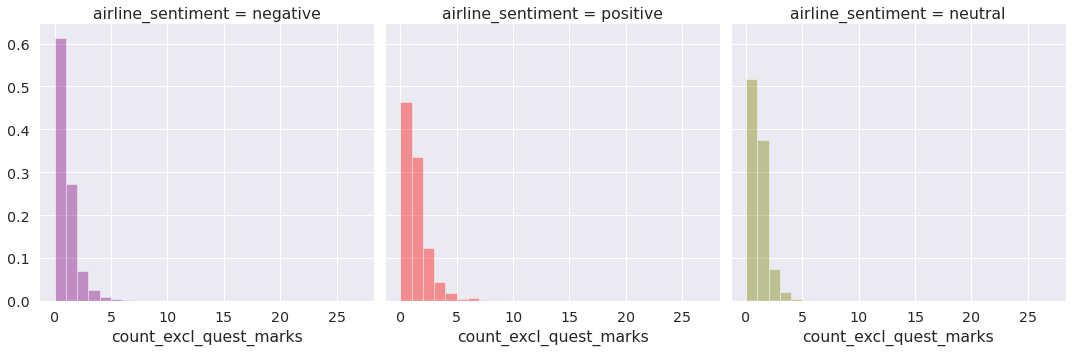

In [12]:
show_dist(df_djb, 'count_excl_quest_marks')

Insights:

The negative tweets seem to be using a bit more exclamation or question marks

Descriptive stats for count_urls
--------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.049248  0.218403  0.0  0.0  0.0  0.0  2.0
neutral            3099.0  0.169732  0.401225  0.0  0.0  0.0  0.0  3.0
positive           2363.0  0.098603  0.303818  0.0  0.0  0.0  0.0  2.0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


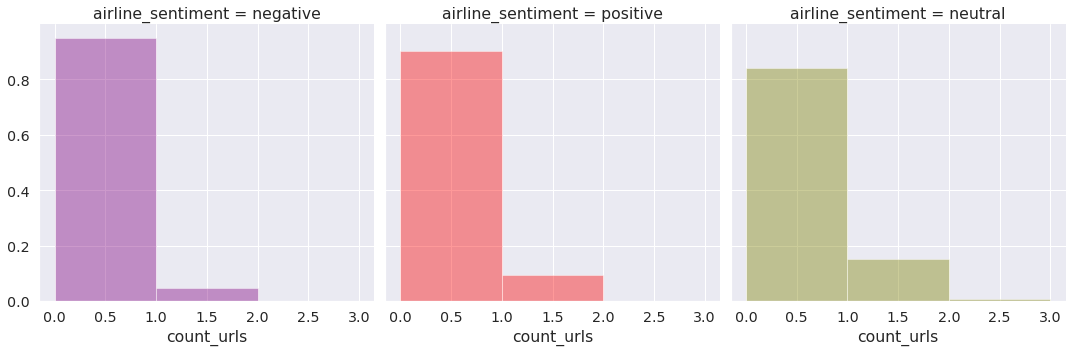

In [13]:
show_dist(df_djb, 'count_urls')

Insights:

Majority of the tweets do not contain URL

Descriptive stats for count_emojis
----------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.028547  0.258772  0.0  0.0  0.0  0.0  8.0 
neutral            3099.0  0.075831  0.492415  0.0  0.0  0.0  0.0  13.0
positive           2363.0  0.181549  1.257512  0.0  0.0  0.0  0.0  40.0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


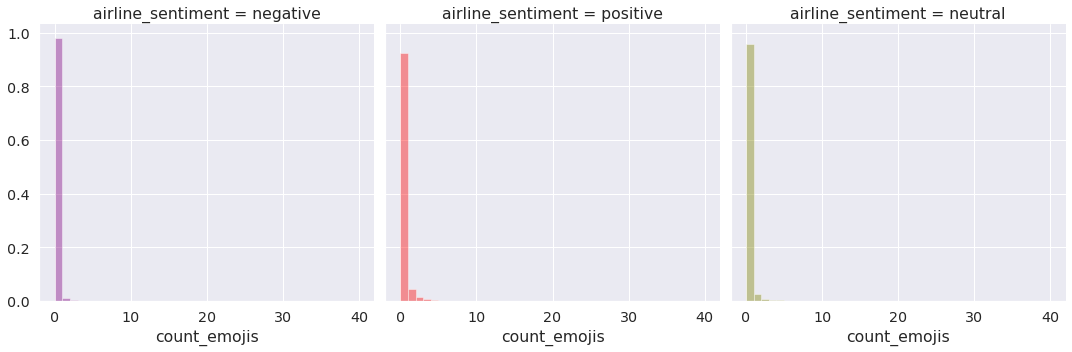

In [14]:
show_dist(df_djb, 'count_emojis')

Insights:
Majority of the tweets do not contain emojis

**Text Cleaning**

In [15]:
class CleanText(BaseEstimator, TransformerMixin):

  # Remove the mentions, I want to generalize to tweets of other airline companies too.
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
  # Remove URLs because they do not contain useful information
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')

  #  Remove all punctuation, including question marks and exclamation marks
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)

  # Set all words to lowercase
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

  # Apply PorterStemmer to keep the st3em of the words   
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [16]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

22 records have no words left after text cleaning


In [17]:

i=1
empty_clean = sr_clean == ''


print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'
print (sr_clean[0:5])

0 records have no words left after text cleaning
0    make premium wifi pay decent slow fi              
1    thank made safe                                   
2    one agent help stagnant line almost custom super  
3    sent dm confirm number passeng name swa mco gt cmh
4    unaccept allow wait hold take number call         
Name: text, dtype: object


In [18]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
#printing only first 20
cv.get_feature_names()[0:20]
#bow.sum(axis=0)

['aa',
 'aaaand',
 'aaadvantag',
 'aaalwaysl',
 'aadavantag',
 'aadelay',
 'aadv',
 'aadvantag',
 'aafail',
 'aal',
 'aaron',
 'aaso',
 'aateam',
 'ab',
 'aback',
 'abandon',
 'abassinet',
 'abbrev',
 'abc',
 'abcletjetbluestreamfe']

      word  freq
0   flight  4879
1   thank   1703
2   get     1623
3   not     1586
4   no      1507
5   hour    1167
6   cancel  1065
7   help    1062
8   delay   1010
9   servic  1002
10  time    987 
11  custom  947 
12  call    792 
13  bag     771 
14  wait    754 
15  plane   735 
16  us      705 
17  fli     702 
18  need    688 
19  hold    687 


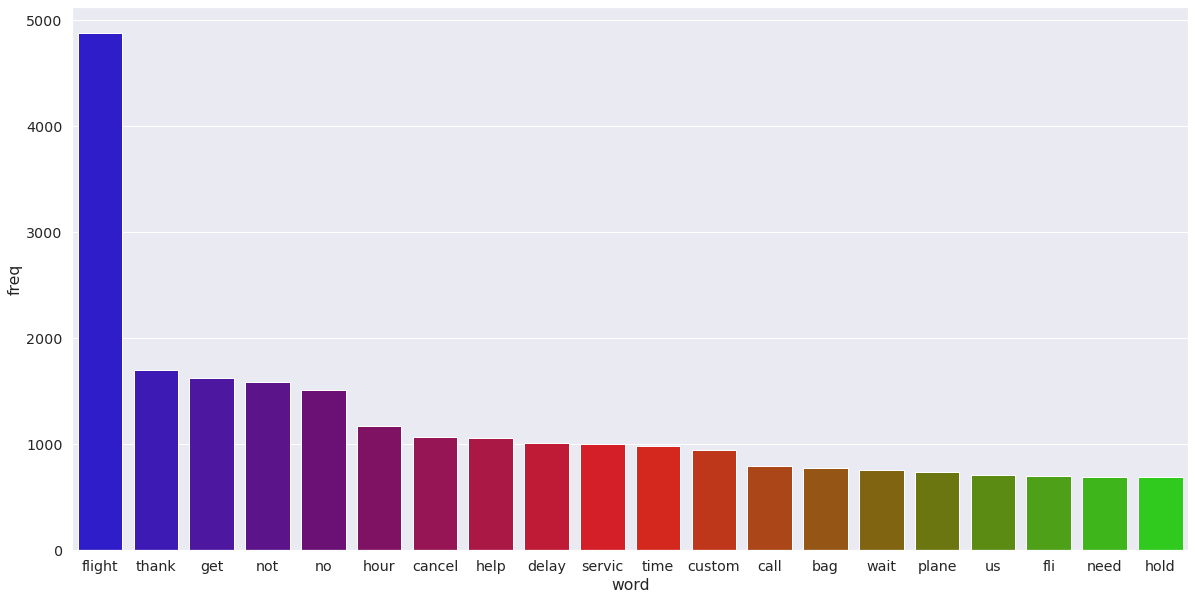

In [19]:
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
print(word_counter_df)

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="brg", ax=ax)
plt.show();

Insights: 

Now that the data is clean the most frequently used word is flight


In [20]:
df_model = df_djb
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'clean_text']

**Hyperparameter tuning and cross validation**

In [21]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        #print("I am in")
        
        #print(X[self.cols].dtype())
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

In [23]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        print("not good")
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        print("ok")
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_train, y_train))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    print("Classification Report Train Data")
    print(classification_report(y_train, grid_search.best_estimator_.predict(X_train)))                    
    return grid_search

In [24]:
# In grid search, I will review the performance of the classifier
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}

parameters_logreg = {
    'clf__C': (1.05, 1.1, 1.15,1.2),
    'clf__penalty': ('l1', 'l2')
}

In [25]:
mnb = MultinomialNB()
logreg = LogisticRegression()

Insights:

* Compare the performance of the Multinomial NB and Logistic Regression


In [26]:
countvect = CountVectorizer()

In [27]:
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   59.1s finished


done in 59.386s

Best CV score: 0.776
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.786


Test score with best_estimator_: 0.832


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.83      0.90      0.87       910
     neutral       0.64      0.52      0.57       295
    positive       0.74      0.69      0.71       259

    accuracy                           0.79      1464
   macro avg       0.74      0.70      0.72      1464
weighted avg       0.78      0.79      0.78      1464

Classification Report Train Data
              precision    recall  f1-score   support

    negative       0.87      0.92      0.89      8268
     neutral       0.73      0.61      0.67      2804
    positive       0.80      0.79      0.79      2104

    accuracy                           0.83     13176
   macro avg

Insights:

Countvectorizer convert the words to numbers by taking all words in all tweets, assigns an ID and counts the frequency of the word per tweet

In [28]:
tfidfvect = TfidfVectorizer()

In [29]:
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   59.7s finished


done in 60.309s

Best CV score: 0.750
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.765


Test score with best_estimator_: 0.849


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.76      0.97      0.85       910
     neutral       0.71      0.35      0.46       295
    positive       0.84      0.52      0.64       259

    accuracy                           0.77      1464
   macro avg       0.77      0.61      0.65      1464
weighted avg       0.76      0.77      0.74      1464

Classification Report Train Data
              precision    recall  f1-score   support

    negative       0.84      0.97      0.90      8268
     neutral       0.87      0.60      0.71      2804
    positive       0.88      0.69      0.78      2104

    accuracy                           0.85     13176
   macro av

Insights:

Because Countvectorizer counts the frequency of the words, in some cases they can be removed. Therefore, the TF-IDF vectorizer can reduce the weight these words to help stablize the data.

In [30]:
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1, 1.15, 1.2),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  7.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


done in 468.687s

Best CV score: 0.759
Best parameters set:
	clf__C: 1.2
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.768


Test score with best_estimator_: 0.778


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.81      0.92      0.86       910
     neutral       0.57      0.43      0.49       295
    positive       0.78      0.61      0.68       259

    accuracy                           0.77      1464
   macro avg       0.72      0.65      0.68      1464
weighted avg       0.76      0.77      0.76      1464

Classification Report Train Data
              precision    recall  f1-score   support

    negative       0.81      0.93      0.87      8268
     neutral       0.66      0.50      0.57      2804
    positive       0.74      0.55      0.63      2104

    accuracy                           0.78     13

Insights:

The Logistic Regression helps to address the negative discriminatory information by using its vector value based on the dimensions of each word multidimensional space remaining in the vocabulary.

In [31]:
import nltk
nltk.download('punkt')

SIZE = 50

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))
X_train['clean_text_wordlist'].head()
model = gensim.models.Word2Vec(X_train.clean_text_wordlist
                 , min_count=1
                 , size=SIZE
                 , window=5
                 , workers=4)

X_train.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,clean_text,clean_text_wordlist
9709,25,1,0,0,1,0,0,denver boston flight boston denver flight plane visibl snack crumb seat upon board,"[denver, boston, flight, boston, denver, flight, plane, visibl, snack, crumb, seat, upon, board]"
12212,14,1,0,0,0,0,0,weekend deal compani would say otherwis,"[weekend, deal, compani, would, say, otherwis]"
11438,21,1,0,0,2,0,0,thank great servic newark seat fix seat daughter fab land fort myer,"[thank, great, servic, newark, seat, fix, seat, daughter, fab, land, fort, myer]"
13844,17,1,0,0,1,0,0,know suicid second lead caus death among teen,"[know, suicid, second, lead, caus, death, among, teen]"
8781,16,1,0,0,0,0,0,worst airlin lost luggag delay flight unaccomid,"[worst, airlin, lost, luggag, delay, flight, unaccomid]"


In [32]:
#The word 'flight' appeared 4879 times
model.most_similar('flight', topn=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('rebook', 0.9875620603561401),
 ('tomorrow', 0.9836346507072449),
 ('flightlat', 0.9781566262245178)]

In [33]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [34]:
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
print(X_train.index)

Int64Index([ 9709, 12212, 11438, 13844,  8781, 12474, 13046,  8006, 12949,
            13903,
            ...
             6595,  5795, 11898,  4118, 12725,   988, 14587,  9036,  4459,
             1935],
           dtype='int64', length=13176)


In [35]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_train_w2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
9709,-0.192104,-0.237120,0.356964,0.206748,0.077760,-0.072677,0.498313,0.070486,0.096926,-0.379485,0.220833,0.378917,-0.669372,-0.263801,-0.822721,0.963510,-0.442809,-0.603595,0.641649,0.517267,0.835352,-0.026135,-0.372312,-0.554324,-0.412056,-0.188631,-0.167607,0.250054,0.683779,0.430530,0.261533,0.001203,0.603135,-0.177750,0.273444,-0.311954,-0.400429,-0.280196,0.207920,0.481083,0.538138,0.236872,0.211694,0.581686,0.453546,-0.093674,0.453604,-0.490846,0.410752,-0.910953,25,1,0,0,1,0,0
12212,-0.142151,-0.334210,0.291871,0.121945,0.043046,-0.281530,0.503765,-0.052534,-0.052605,-0.399192,0.105826,0.264008,-0.609948,-0.273430,-1.020273,0.837823,-0.683896,-0.691424,0.649091,0.416124,0.746799,0.085671,-0.423440,-0.624984,-0.496768,-0.070591,0.001819,0.115550,0.621509,0.558209,0.297366,0.070039,0.691652,-0.178084,0.314652,-0.211731,-0.426381,-0.408595,0.237136,0.513953,0.404445,0.250094,0.168732,0.383884,0.488201,-0.135086,0.418262,-0.402831,0.442684,-0.973091,14,1,0,0,0,0,0
11438,-0.176751,-0.375638,0.289869,0.116746,0.019973,-0.307780,0.513254,-0.069755,-0.053022,-0.380909,0.089201,0.255439,-0.616274,-0.303198,-1.028593,0.853726,-0.699460,-0.742522,0.682304,0.416635,0.775160,0.090596,-0.413820,-0.644843,-0.522879,-0.064515,-0.000580,0.124733,0.639468,0.577251,0.296975,0.085174,0.733322,-0.217333,0.335107,-0.224795,-0.431197,-0.404123,0.245691,0.522720,0.404934,0.245714,0.182095,0.403112,0.496066,-0.141591,0.422580,-0.433115,0.432399,-0.991435,21,1,0,0,2,0,0
13844,-0.090340,-0.188221,0.175456,0.076008,0.024040,-0.154297,0.291241,-0.020765,-0.024759,-0.230651,0.068402,0.160825,-0.354666,-0.157207,-0.572781,0.495079,-0.375546,-0.391524,0.374722,0.246360,0.433847,0.037928,-0.240189,-0.348735,-0.278508,-0.050830,-0.009281,0.078683,0.366538,0.309933,0.171512,0.031404,0.395783,-0.098049,0.178849,-0.128910,-0.247618,-0.224521,0.137921,0.301816,0.244585,0.135742,0.095916,0.235564,0.275881,-0.079418,0.244878,-0.241941,0.254555,-0.557434,17,1,0,0,1,0,0
8781,-0.294146,-0.392771,0.430440,0.245985,0.012439,-0.165707,0.638911,0.019850,0.084331,-0.437776,0.256822,0.431667,-0.823977,-0.377923,-1.079899,1.199633,-0.620300,-0.871597,0.870247,0.629399,1.074412,0.038334,-0.482637,-0.761413,-0.602363,-0.217575,-0.178198,0.289945,0.854456,0.606846,0.321615,0.054590,0.829818,-0.282679,0.385917,-0.397205,-0.526839,-0.401294,0.273019,0.619557,0.656217,0.308639,0.301052,0.705344,0.588784,-0.133828,0.605536,-0.637975,0.493747,-1.183336,16,1,0,0,0,0,0


In [36]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)

not good
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1, 1.15, 1.2), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


done in 15.782s

Best CV score: 0.685
Best parameters set:
	clf__C: 1.1
	clf__penalty: 'l2'
Test score with best_estimator_: 0.680


Test score with best_estimator_: 0.683


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.72      0.93      0.81       910
     neutral       0.45      0.23      0.30       295
    positive       0.63      0.31      0.41       259

    accuracy                           0.68      1464
   macro avg       0.60      0.49      0.51      1464
weighted avg       0.65      0.68      0.64      1464

Classification Report Train Data
              precision    recall  f1-score   support

    negative       0.72      0.92      0.81      8268
     neutral       0.51      0.30      0.38      2804
    positive       0.56      0.26      0.36      2104

    accuracy                           0.68     13176
   macro avg       0.60      0.50      0.52     13176
weighted avg       0.65      0.68      0.65     13176


In [37]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LogisticRegression(C=1.0, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**Sentiment Classification**

In [38]:
new_positive_tweets = pd.Series(["@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."
                      ,"@SouthwestAir Love, love, love this. Southwest Rocks!! Always!! https://t.co/q8VSfFRd1u"
                      ,"@united Thanks to Karen Salisbury at IAH for amazing customer service!  Found my daughter's bag lost on UA1516.  Made her day!"])

df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

best_model.predict(df_model_pos).tolist()

['positive', 'positive', 'positive']

In [39]:
new_negative_tweets = pd.Series(["@united A measly $50 e-certificate is not how you appreciate loyal customers after they wait 3hrs on the tarmac during UA1116. #unacceptable"
                      ,"@VirginAmerica lost my luggage 4 days ago on flight VX 112 from LAX to IAD &amp; I'm calling every day, no response.Please give me back my stuff"
                      ,"@USAirways have been waiting in an airplane for a total of 3 hours to take off between 2 flights today...this usually doesn't happen..."])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

best_model.predict(df_model_neg).tolist()

['negative', 'negative', 'negative']

In [40]:
X_test

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,clean_text,clean_text_wordlist
10620,26,1,1,1,1,0,0,phl take hour offload bag especi take min get jetway get plane land,"[phl, take, hour, offload, bag, especi, take, min, get, jetway, get, plane, land]"
13609,17,1,0,1,0,0,0,past tens help no it’ even miser usual clt,"[past, tens, help, no, it, ’, even, miser, usual, clt]"
2955,11,2,0,0,0,0,0,eventu approach bag like get,"[eventu, approach, bag, like, get]"
3585,21,1,0,2,1,0,0,broken luggag mild case food poison ua lhr iah email,"[broken, luggag, mild, case, food, poison, ua, lhr, iah, email]"
2087,25,1,0,0,0,0,0,can empath think team lost right capit lowercas team day,"[can, empath, think, team, lost, right, capit, lowercas, team, day]"
...,...,...,...,...,...,...,...,...,...
3933,21,1,0,0,1,0,0,flight cancel flight tomorrow hold time long cancel flight leg,"[flight, cancel, flight, tomorrow, hold, time, long, cancel, flight, leg]"
3089,12,1,0,0,0,0,0,breath heavili super help thank,"[breath, heavili, super, help, thank]"
11579,29,1,0,1,0,0,0,got gate iah time given seat close flight know peopl arriv wait,"[got, gate, iah, time, given, seat, close, flight, know, peopl, arriv, wait]"
8987,8,1,0,0,3,0,0,oh get ticket,"[oh, get, ticket]"


In Conclusion:

The vectorizers classification (CountVectorizer, TF-IDF vectorizer and Log Regression w/TF-IDF vectorizer) all done really well with favorable results. 
* The **accuracy** for all three classification category test data:
  * .79 vs .83 (train data)
  * .77 vs .85 (train data)
  * .77 vs .78 (train data)

Note: Accuracy is relatively high for all classification class with prediction of negative

* The **recall** for all three classification category test data:
 * CountVectorizer
   * Negative .90 vs .92 (train data)
   * Neutral .52 vs .61 (train data)
   * Positive .69 vs .79 (train data)
 * TF-IDF Vectorizer
   * Negative .97 vs .97 (train data)
   * Neutral .35 vs .60 (train data)
   * Positive .52 vs .69 (train data)
 * TF-IDF Vectorizer plus Log Regression
   * Negative .93 vs .93 (train data)
   * Neutral .43 vs .50 (train data)
   * Positive .61 vs .55 (train data)

Note: Recall for neutral class is very low in both test and training data set

* The **precision** for all three classification category test data:
 * CountVectorizer
   * Negative .83 vs .87 (train data)
   * Neutral .64 vs .73 (train data)
   * Positive .74 vs .80 (train data)
 * TF-IDF Vectorizer
   * Negative .76 vs .84 (train data)
   * Neutral .71 vs .87 (train data)
   * Positive .84 vs .88 (train data)
 * TF-IDF Vectorizer plus Log Regression
   * Negative .81 vs .81 (train data)
   * Neutral .57 vs .66 (train data)
   * Positive .78 vs .74 (train data)
   
Note: Precision is relatively high for all classification class with prediction of negative
